# Background

The streamfunction, $\Psi$, is defined as:
$$\Psi(x,y) = \frac{\phi_0}{f_0} \left( 1 - A \exp{\left[- \frac{(x-{x_0}_{\psi})^2 + (y-{y_0}_{\psi})^2}{2 \sigma^2_{\psi}}\right]}\right) $$

We also have the vorticity field, $\xi$, as a function of the streamfunction:

$$ \xi = \frac{\partial^2 \Psi}{\partial x^2} + \frac{\partial^2 \Psi}{\partial y^2}$$

In [2]:
import sys
sys.path.append('Functions') # add 'Functions' folder to system-recognised path in order to import .py file and functions from within a nested folder.

import numpy as np
import matplotlib.pyplot as plt
import scienceplots 
from numpy.fft import rfft, rfftfreq, irfft 
plt.style.use('science')

from Functions.grid_interpolation import *

In [3]:
# constants
phi_0     = 1e5
f_0       = 1e-4
x_0_psi   = 1.25e7
y_0_psi   = 2.5e6
A         = 3e-2
sigma_psi = 7.5e5

# duration of simulation
duration  = 6 * 24 * 60 * 60 # 12 days in seconds
dt        = 60 * 60 # 1 hour in seconds
num_steps = duration/dt # number of timesteps

Set up a grid

In [4]:
# common grid spacing
grid_space = 2.5e4

# adding 1e5 to both limits so that np.arrange() includes the upper limit
upper_x_limit = 2.5e7 + grid_space
upper_y_limit = 5e6 + grid_space

x = np.arange(0, upper_x_limit, grid_space)
y = np.arange(0, upper_y_limit, grid_space)

# define 2D X and Y arrays:
Y, X = np.meshgrid(y, x)

We define the streamfunction as follows:

In [5]:
psi  = phi_0/f_0 * (1 - (A * np.exp(-((X-(x_0_psi))**2 + (Y-y_0_psi)**2)/(2 * (sigma_psi**2)))))

Vorticity, with periodicity in the x-direction is defined as:

$$ \xi = \frac{\partial^2 \Psi}{\partial x^2} + \frac{\partial^2 \Psi}{\partial y^2} $$

In [6]:
def generate_vorticity(streamfunction, y, x):
    N = np.shape(y)[1]  # length in the y direction
    M = np.shape(x)[0]
    dx = dy = y[0, 1] - y[0, 0]  # extract grid space step from y array
    
    # Implement the 3 point centred difference scheme for the interior points of the vorticity
    d_y_2 = (streamfunction[:, 2:N] - 2 * streamfunction[:, 1:(N-1)] + streamfunction[:, 0:(N-2)]) / (dy**2)

    d_x_2 = (streamfunction[2:M, 1:(N-1)] - 2 * streamfunction[1:(M-1), 1:(N-1)] + streamfunction[0:(M-2), 1:(N-1)]) / (dx**2)

    # Implement the boundary conditions for the second derivative with respect to x
    d_x_2_first = (streamfunction[1, 1:(N-1)] - 2*streamfunction[0, 1:(N-1)] + streamfunction[-1, 1:(N-1)]) / (2 * dx)
    d_x_2_last  = (streamfunction[0, 1:(N-1)] - 2*streamfunction[-1, 1:(N-1)] + streamfunction[-2, 1:(N-1)]) / (2 * dx)

    # Stack the boundary conditions onto the second derivative arrays
    d_x_2 = np.vstack((d_x_2_first, d_x_2))
    d_x_2 = np.vstack((d_x_2, d_x_2_last))

    # Combine the second derivatives to calculate the vorticity
    xi = d_x_2 + d_y_2
    
    return xi

xi = generate_vorticity(psi, Y, X)

Text(0.5, 0, 'x (m)')

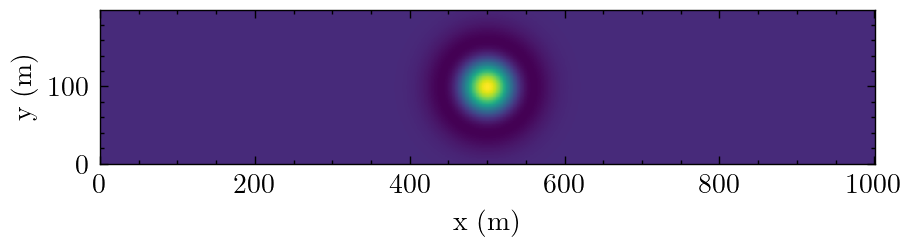

In [7]:
plt.figure(figsize=(5,5), dpi=200)
plt.axes(aspect='equal')
plt.pcolormesh(xi.T)
plt.ylabel('y (m)')
plt.xlabel('x (m)')

Recall that we want to solve the problem:

$$\frac{\partial^2 \Psi}{\partial x^2} + \frac{\partial^2 \Psi}{\partial y^2} = \xi$$

If we apply the fourier transform to our known $\xi(x_p, y_q) \equiv \xi_{p,q}$ in the x-direction, we get an equation relating the x-Fourier Transform at wavenumber ($k$) points m and y points:

$$ \hat{\xi} = - k^2 \hat{\Psi} + \frac{\partial^2 \hat{\Psi}}{\partial y^2}; \; k = m \frac{2 \pi}{L_x} $$

So we first want to use the Fast Fourier Transform (FFT) function to Fourier Transform $\xi(x,y)$ in the x-direction to $\hat{\xi}(k,y)$:

In [8]:
xi_hat = rfft(xi, axis=0)

np.shape(xi_hat)

(501, 199)

Now to solve the problem:
$$ \hat{\xi} = - k^2 \hat{\Psi} + \frac{\partial^2 \hat{\Psi}}{\partial y^2}; \; k = m \frac{2 \pi}{L_x} $$

We invoke finite differences:
$$\hat{\xi}_{m,q} = \lambda_m \hat{\Psi}_{m,q} + \frac{\hat{\Psi}_{m,q-1} - 2\hat{\Psi}_{m,q} + \hat{\Psi}_{m,q+1}}{\Delta y^2}$$

Where:
$${\lambda}_m = -(m \Delta k)^2$$

So we first generate the set of fourier coefficients for the streamfunction. These will be used as the boundary conditions when solving the tri-diagonal system of equations.

In [9]:
psi_hat = rfft(psi, axis=0)

northern_boundary = psi_hat[:, 0]
southern_boundary = psi_hat[:, -1]

Now we can set up our RHS solution vector:

In [10]:
# first we add an axis to both the northern and southern boundary arrays
northern_boundary = northern_boundary[:, np.newaxis]
southern_boundary = southern_boundary[:, np.newaxis]

# then we concatenate the arrays together along the column axis
xi_hat = np.concatenate((northern_boundary, xi_hat, southern_boundary), axis=1)

np.shape(xi_hat)

(501, 201)

Then we calculate the wavenumber corresponding to each m value:

In [11]:
k = rfftfreq(np.shape(x)[0], grid_space/(2.0*np.pi))

And we define the function that creates the tri-diagonal matrix as specified in the task brief:

In [12]:
def generate_tridiagonal_matrix(N, k, grid_spacing):

    # define variables and constants
    dy = grid_spacing
    lambda_ = -(k**2)

    # initiate matrix
    matrix = np.zeros((N,N))
    F = 1/(dy**2)

    # fill the matrix with the correct values by looping through the rows first, then the columns:
    for i in range(N): 
        for j in range(N): 

            # fill the corners of the matrix with 1:
            if (i == j == 0) or (i == j == N-1): 
                matrix[i,j] = 1 
                
            # fill the rest of the matrix with the correct values    
            else:

                # if the row and column are the same, fill the diagonal with -2F
                if i == j: 
                    matrix[i,j] = lambda_ - (2*F)

                # if the row and column are next to each other, fill the matrix with F
                elif (i == j+1 or i == j-1) and (i != 0 and i != N-1):
                    matrix[i,j] = F

    return matrix

And now we loop over each column, solving the tri-diagonal system of equations for every value of y:

In [13]:
np.shape(x)[0]

1001

In [14]:
# Create an empty 2D array to store psi_hat values
psi_hat_array = np.empty((np.shape(psi_hat)[0], 0))

# save number of columns to a variable for use in the loop
num_columns = np.shape(Y)[1]

psi_new = np.copy(xi_hat)

# Loop through the number of columns and solve the tridiagonal matrix for each y-value:
for i in range(num_columns):
    N = np.shape(xi_hat)[1]
    matrix = generate_tridiagonal_matrix(N, k[i], grid_space)

    # Solve the system of equations
    psi_new[i, :] = np.linalg.solve(matrix, xi_hat[i, :])

# Inverse Fourier transform the psi_hat_array to get the streamfunction
psi_new = irfft(psi_new, axis=0, n=np.shape(x)[0])
